# Linear Regression in Python - sklearn and statsmodels

- Linear regression is a statistical modeling technique, used to show the relationship between one dependent variable (target) and one or more independent variable. It is one of the most common types of predictive analysis. 
- Dataset was obtained in the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php).  
- I will use the article [The Five Assumptions of Multiple Linear Regression](https://www.statology.org/multiple-linear-regression-assumptions/) to guide my analysis.
- Please check the [conclusion](http://localhost:8888/lab#Conclusion) in the end.

### EDA and feature selection

In [1]:

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split as tts
from sklearn.linear_model import LinearRegression 
from sklearn import metrics 
import random
np.random.seed(1)

get_ipython().run_line_magic('matplotlib', 'inline')

https://archive.ics.uci.edu/ml/datasets/Fertility

Dataset citation:  
Salam, A., & El Hibaoui, A. (2018, December). Comparison of Machine Learning Algorithms for the Power Consumption Prediction:-Case Study of Tetouan cityâ€“. In 2018 6th International Renewable and Sustainable Energy Conference (IRSEC) (pp. 1-5). IEEE.â€

In [2]:
df = pd.read_csv('Bases de Dados\Tetuan_power_consumption.csv')
print(df.shape)
df.head()

(52416, 9)


,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption
0,1/1/2017 0:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
1,1/1/2017 0:10,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2,1/1/2017 0:20,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
3,1/1/2017 0:30,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
4,1/1/2017 0:40,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964


In [3]:
df['Total Power Consumption'] = df['Zone 1 Power Consumption'] + df['Zone 2  Power Consumption'] + df['Zone 3  Power Consumption']
df.drop(['Zone 1 Power Consumption', 'Zone 2  Power Consumption', 'Zone 3  Power Consumption', 'DateTime'], 
             axis=1, inplace=True)

### Histogram
- Check how normally distribuited is the data:  
- This data is skewed to the right

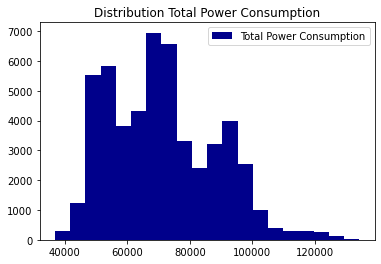

In [4]:
plt.hist(df["Total Power Consumption"], bins = 20
        , histtype = "stepfilled"
        , color = "darkblue"
        , edgecolor = "none"
        , label = "Total Power Consumption");

plt.legend()
plt.title("Distribution Total Power Consumption");

### Checking and vizualizing correlations

In [5]:
correl = df.corr()['Total Power Consumption'].drop('Total Power Consumption')
correl

Temperature              0.488238
Humidity                -0.299059
Wind Speed               0.221706
general diffuse flows    0.150368
diffuse flows            0.032068
Name: Total Power Consumption, dtype: float64

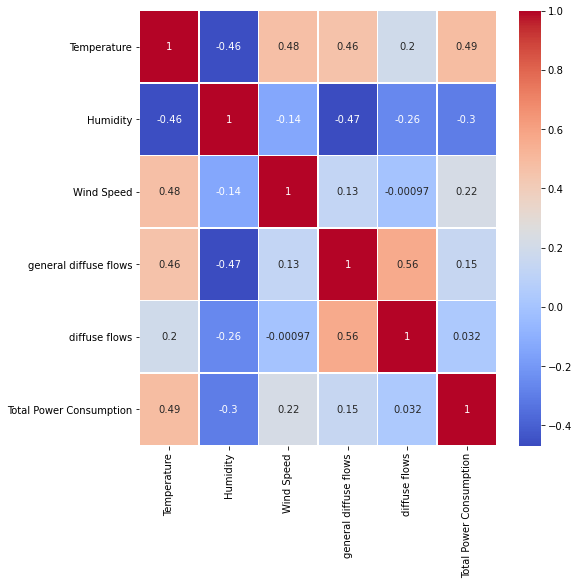

In [6]:
# Vizualizing correlations
correl_hm = df.corr()

fig, ax = plt.subplots(figsize=(8,8))

sns.heatmap(correl_hm, cmap = "coolwarm", annot=True, linewidths=.4, ax = ax);

### Eliminate highly correlated variables and rewriting the dataset
- No Multicollinearity - Assumption 2 of article: [The Five Assumptions of Multiple Linear Regression](https://www.statology.org/multiple-linear-regression-assumptions/).
- Independence - Assumption 3 of article: [The Five Assumptions of Multiple Linear Regression](https://www.statology.org/multiple-linear-regression-assumptions/).

In [7]:
correl_total = df.corr().abs()

superior = correl_total.where(np.triu(np.ones(correl_total.shape), k = 1).astype(np.bool))

var_remove = [variaveis for variaveis in superior.columns if any(superior[variaveis] > 0.5)]

df = df.drop(df[var_remove], axis=1)

### Checking outliers
- in this case, we may have outliers on:  
    `general diffuse flows`: maximum value is very far from third quartile value;  
    `Wind Speed`: third quartile is far from median

In [8]:
df.describe()

,Temperature,Humidity,Wind Speed,general diffuse flows,Total Power Consumption
count,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000
mean,18.810024,68.259518,1.959489,182.696614,71222.885864
std,5.815476,15.551177,2.348862,264.400960,17143.138964
min,3.247000,11.340000,0.050000,0.004000,36785.039739
25%,14.410000,58.310000,0.078000,0.062000,56499.074640
50%,18.780000,69.860000,0.086000,5.035500,69788.790940
75%,22.890000,81.400000,4.915000,319.600000,83749.172310
max,40.010000,94.800000,6.483000,1163.000000,134208.145950


### Splitting Target/Variables and Train/Test 

In [9]:
y = df['Total Power Consumption'] #define target
x = df.drop('Total Power Consumption', axis=1) # drop target from variables

In [10]:
# separate train and test DFs
x_train, x_test, y_train, y_test = tts(x, y, test_size=0.3) 

## Linear Regression using sklearn  
### Model selection and training

In [11]:
lr = LinearRegression()

lr.fit(x_train, y_train)

LinearRegression()

### Predicitons

In [12]:
y_pred_train = lr.predict(x_train)
y_pred_test = lr.predict(x_test)

### Evaluation metrics
- Coefficient of determination or R2 score:  is used to evaluate the performance of a linear regression model. It is the amount of the variation in the target which is predictable from the variables.  
- Mean Absolute Error or MAE: calculates the average difference between the calculated values and actual values.
- I run both MAE and R2 on train and test datasets to check how stable the model is;  
    Stability does not mean quality, stablity only mean that the model learned. (it may have learned wrong)

In [13]:
# Avaliaçao dos resultados
import sklearn.metrics as metrics
from math import sqrt

MAE_train = metrics.mean_absolute_error(y_train, y_pred_train) 
R2_train = metrics.r2_score(y_train, y_pred_train)

print("----- Train Evaluation -----")
print("MAE: ", round(MAE_train,2))
print('R2: ', round(R2_train,2))

MAE_test = metrics.mean_absolute_error(y_test, y_pred_test) 
R2_test = metrics.r2_score(y_test, y_pred_test)

print("")
print("----- Test Evaluation -----")
print("MAE: ", round(MAE_test,2))
print('R2: ', round(R2_test,2))

----- Train Evaluation -----
MAE:  12034.54
R2:  0.26

----- Test Evaluation -----
MAE:  12053.21
R2:  0.26


### Relation between MAE and test mean.
- How well the model learned ?  
    if the MAE value is 10% the average value of the target, the model learned well.

In [14]:
test_avg = round(y_test.mean(), 2)
MAE_ratio = round(MAE_test/test_avg * 100, 2)
print("Average Consumption: ", test_avg)
print("MAE percentage in relation to the base average: ", MAE_ratio)
print("This model could be better")

Average Consumption:  71078.72
MAE percentage in relation to the base average:  16.96
This model could be better


### Regression coefficients and intercept

In [15]:
coef = pd.DataFrame({'Coefs':lr.coef_}, df.columns[0:4])
coef

,Coefs
Temperature,1464.319368
Humidity,-148.459541
Wind Speed,-99.684794
general diffuse flows,-9.039989


In [16]:
lr.intercept_

55653.212820757755

### The regression equation is:  
#### `lr = 55653.212820757755 + (1464.319368 * Temperature) - (148.459541 * Humidity) - (99.684794 * Wind Speed) - (9.039989 * general diffuse flows)`

The higher the coeficient, higher should be the variation in the result (the opposite is true), for instance:  
For every 1 unit in increase in `Temperature` we should see a **INCREASE** of 1464.32 units in the result `Zone 1 Power Consumption`  
When `Humidity` increase 1 unit we should see a 148.46 units **DECREASE** in the result `Zone 1 Power Consumption`

In [17]:
medias = df.describe().loc['mean']
medias = [medias]
medias

[Temperature                   18.810024
 Humidity                      68.259518
 Wind Speed                     1.959489
 general diffuse flows        182.696614
 Total Power Consumption    71222.885864
 Name: mean, dtype: float64]

In [18]:
## 1 unit increase check
var_means = lr.predict([[18.81, 68.25, 1.95, 182.69]]) 
hummidity_1unit = lr.predict([[18.81, 69.25, 1.95, 182.69]])
print(var_means)
print(hummidity_1unit)
print(var_means- hummidity_1unit)

[71218.79547667]
[71070.33593539]
[148.45954128]


### Vizualing Results

In [19]:
# Resultados: Real x previsto em um dataframe
resultados = pd.DataFrame({'Real': y_test, 'Predict': y_pred_test})
resultados

,Real,Predict
41095,65228.218500,76222.658691
34590,58852.505730,76893.952618
25316,100790.412090,77156.025072
45441,68508.164580,74098.475952
11318,71519.735840,63070.390546
...,...,...
50240,83534.538790,64753.661647
29900,103450.497740,83746.209832
9133,57865.096910,64667.541095
47304,66110.304464,71748.836616


<AxesSubplot:title={'center':'Linear Regression'}, xlabel='Total Power Consumption', ylabel='Real Consumption'>

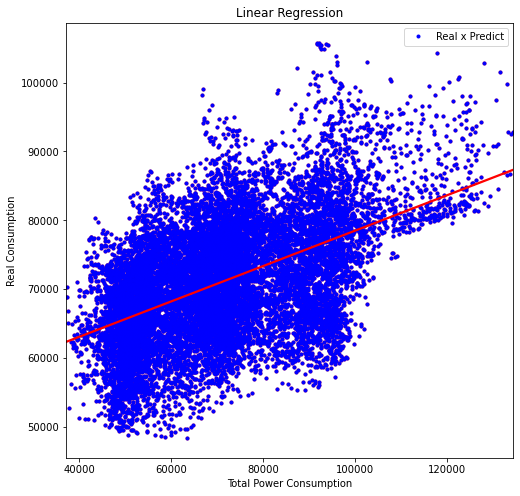

In [20]:
# Grafico dos resultados
plt.figure(figsize = (8,8))
plt.plot(y_test, y_pred_test, ".", color = "blue", label = "Real x Predict")
plt.legend()
plt.xlabel("Predicted Consumption")
plt.ylabel("Real Consumption")
plt.title("Linear Regression")
sns.regplot(y_test, y_pred_test, ci=None, color='red', marker=".")

### Linear Regression using statsmodels

In [21]:
#pip install statsmodels

import statsmodels.api as sm
from statsmodels.formula.api import ols

### Model selection and training
- statsmodels uses ordinary least squares (OLS) as method of linear regression 
- statsmodels does not add intercept, therefore I add it mannualy to train and test data

In [22]:
x_train_ = sm.add_constant(x_train) ## adding intercept column
x_test_ = sm.add_constant(x_test) ## adding intercept column

lr_sm = sm.OLS(y_train, x_train_).fit() ## model selection and training

### Predictions and summary
- statsmodels give a comprehensive table, in it we have:
    - R2 score, R-squared
    - Coeficients
    - P-values (to check how significant each single variable is, values above 0.005 can be excluded from model*)
    - Jarque-Bera (to check if the residuals tend to normality, values closer to ZERO are better)
        - It helps explain the low R2 score
        - Multivariate Normality - Assumption 5 of article: [The Five Assumptions of Multiple Linear Regression](https://www.statology.org/multiple-linear-regression-assumptions/).
    
###### *respecting business rules  


In [23]:
y_pred_train_sm = lr_sm.predict(x_train_) 
y_pred_test_sm = lr_sm.predict(x_test_)

# Print out the statistics
lr_sm.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     Total Power Consumption   R-squared:                       0.259
Model:                                 OLS   Adj. R-squared:                  0.259
Method:                      Least Squares   F-statistic:                     3212.
Date:                     Sat, 09 Apr 2022   Prob (F-statistic):               0.00
Time:                             06:07:44   Log-Likelihood:            -4.0426e+05
No. Observations:                    36691   AIC:                         8.085e+05
Df Residuals:                        36686   BIC:                         8.086e+05
Df Model:                                4                                         
Covariance Type:                 nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  5.565e+04    593.453     93.779      0.000    5.45e+04    5.68e+04
Temperature            1464.3194     17.857     82.005      0.000    1429.320    1499.319
Humidity               -148.4595      5.908    -25.127      0.000    -160.040    -136.879
Wind Speed              -99.6848     37.694     -2.645      0.008    -173.566     -25.803
general diffuse flows    -9.0400      0.348    -26.010      0.000      -9.721      -8.359
==============================================================================
Omnibus:                     1375.005   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1295.540
Skew:                           0.412   Prob(JB):                    4.76e-282
Kurtosis:                       2.590   Cond. No.                     2.49e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.49e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Evaluation metrics

In [24]:
# Avaliação dos Resultados com STATSMODELS

MAE_train_sm = sm.tools.eval_measures.meanabs(y_train, y_pred_train)
R2_train_sm = lr_sm.rsquared 

print("----- Train Evaluation -----")
print("MAE: ", round(MAE_train_sm,2))
print('R2: ', round(R2_train_sm,2))

MAE_test_sm = sm.tools.eval_measures.meanabs(y_test, y_pred_test) 
RMSE_test_sm = sm.tools.eval_measures.rmse(y_test, y_pred_test)

print("")
print("----- Test Evaluation -----")
print("MAE: ", round(MAE_test_sm,2))
print("statsmodels library doesn't calculate R2 for y_test")

----- Train Evaluation -----
MAE:  12034.54
R2:  0.26

----- Test Evaluation -----
MAE:  12053.21
statsmodels library doesn't calculate R2 for y_test


In [25]:
test_avg = round(y_test.mean(), 2)
MAE_ratio = round(MAE_test_sm/test_avg * 100, 2)
print("Average Consumption: ", test_avg)
print("MAE percentage in relation to the base average: ", MAE_ratio)
print("This model could be better")

Average Consumption:  71078.72
MAE percentage in relation to the base average:  16.96
This model could be better


### Coefficients and Intercept (const)

In [26]:
# Mostrando os coeficientes (pesos) da regressao
intercpt_coefs_sm = pd.DataFrame(lr_sm.params)
intercpt_coefs_sm

,0
const,55653.212821
Temperature,1464.319368
Humidity,-148.459541
Wind Speed,-99.684794
general diffuse flows,-9.039989


### Residuals x Fitted Values
- Homoscedasticity - Assumption 5 of article: [The Five Assumptions of Multiple Linear Regression](https://www.statology.org/multiple-linear-regression-assumptions/)
- Homoscedasticity occurs when the variance of the error in the model is constant, If the variance of the error term is homoskedastic, the model was well-defined - [Homoskedastic](https://www.investopedia.com/terms/h/homoskedastic.asp)

<AxesSubplot:title={'center':'Wine - Residuals x Fitted Values'}>

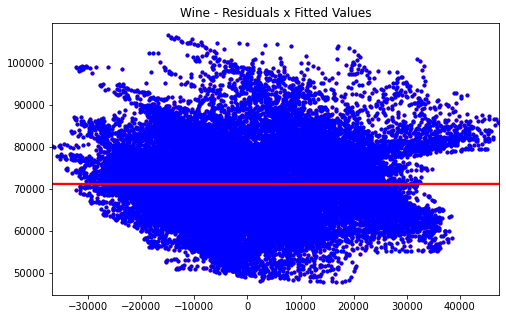

In [27]:
plt.figure(figsize = (8,5))
plt.plot(lr_sm.resid, y_pred_train_sm, ".", color = "blue")
plt.xlabel("Residuals")
plt.ylabel("Fitted Values")
plt.title("Wine - Residuals x Fitted Values")
sns.regplot(lr_sm.resid, y_pred_train_sm,marker='.', color="red")

### Normality plot
- Multivariate Normality - Assumption 5 of article: [The Five Assumptions of Multiple Linear Regression](https://www.statology.org/multiple-linear-regression-assumptions/)
- Multiple linear regression assumes that the residuals of the model are normally distributed.
- The data values occur at a larger rate in the between first and third quartiles [A Q-Q Plot Dissection Kit](https://seankross.com/2016/02/29/A-Q-Q-Plot-Dissection-Kit.html)

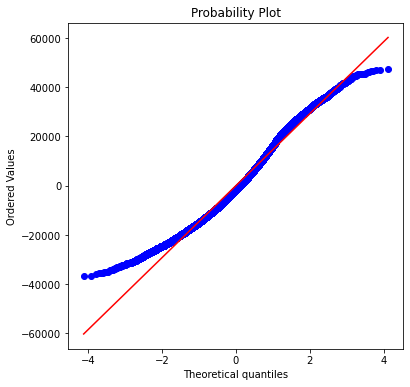

In [28]:
import scipy as sp

fig, ax = plt.subplots(figsize=(6,6))

sp.stats.probplot(lr_sm.resid, plot = ax, fit = 1);

- below is the distribuition of the residuals in orange and what a normal distribution would look like in blue.  
[How to use numpy random normal in Python](https://www.sharpsightlabs.com/blog/numpy-random-normal/)

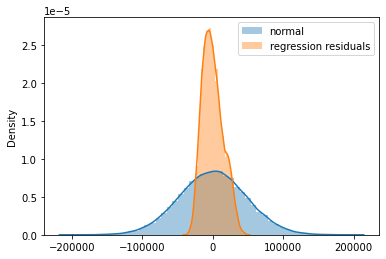

In [55]:
np.random.seed(1)
norm = np.random.normal(loc = 0, scale=max(lr_sm.resid), size=(len(lr_sm.resid),1))

sns.distplot(norm, label='normal')
sns.distplot(lr_sm.resid, label='regression residuals')
plt.legend();

### Linear Relationship
- Linear Relationship - Assumption 1 of article: [The Five Assumptions of Multiple Linear Regression](https://www.statology.org/multiple-linear-regression-assumptions/)
- Multiple linear regression assumes that there is a linear relationship between each predictor variable and the response variable.
- Here we see that `wind speed` variable might not be relevant for target prediction.

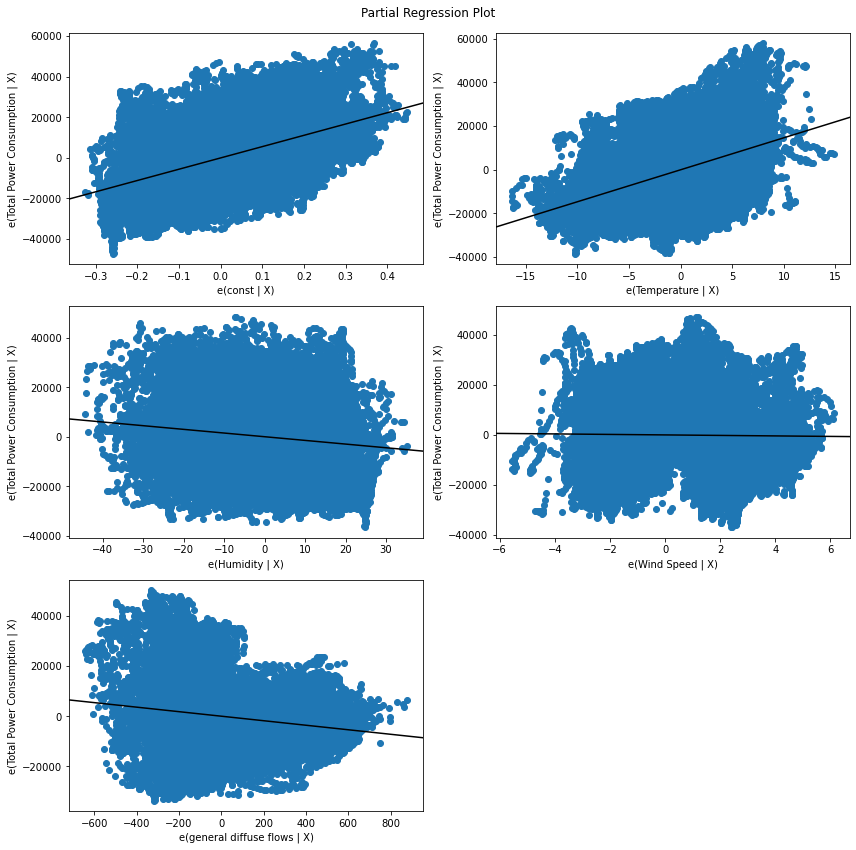

In [30]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,12))

fig = sm.graphics.plot_partregress_grid(lr_sm, fig = fig)

### Retraining model, without `wind speed` variable.

In [31]:
df.columns

Index(['Temperature', 'Humidity', 'Wind Speed', 'general diffuse flows',
       'Total Power Consumption'],
      dtype='object')

In [32]:
df2 = df.drop(['Wind Speed'], axis=1)

x = df2.drop('Total Power Consumption', axis = 1)
y = df2['Total Power Consumption']

x_train, x_test, y_train, y_test = tts(x, y, test_size = 0.30)

x_train_ = sm.add_constant(x_train)
x_test_ = sm.add_constant(x_test)

lr_sm2 = sm.OLS(y_train, x_train_).fit()

y_pred_train_sm = lr_sm2.predict(x_train_)

y_pred_test_sm = lr_sm2.predict(x_test_)

# Print out the statistics
lr_sm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     Total Power Consumption   R-squared:                       0.260
Model:                                 OLS   Adj. R-squared:                  0.259
Method:                      Least Squares   F-statistic:                     4286.
Date:                     Sat, 09 Apr 2022   Prob (F-statistic):               0.00
Time:                             06:07:53   Log-Likelihood:            -4.0430e+05
No. Observations:                    36691   AIC:                         8.086e+05
Df Residuals:                        36687   BIC:                         8.086e+05
Df Model:                                3                                         
Covariance Type:                 nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  5.626e+04    583.075     96.483      0.000    5.51e+04    5.74e+04
Temperature            1443.0473     15.740     91.683      0.000    1412.197    1473.897
Humidity               -154.5037      5.907    -26.156      0.000    -166.082    -142.926
general diffuse flows    -9.0640      0.347    -26.156      0.000      -9.743      -8.385
==============================================================================
Omnibus:                     1388.592   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1292.686
Skew:                           0.409   Prob(JB):                    1.98e-281
Kurtosis:                       2.580   Cond. No.                     2.45e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.45e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Comparing models

In [33]:
print('NEW MODEL, without wind speed variable. ')
print(lr_sm2.summary())
print('\n-----------------------------------------------------------------------------------\n')
print('OLD MODEL')
print(lr_sm.summary())
print('\n')

NEW MODEL, without wind speed variable. 
                               OLS Regression Results                              
Dep. Variable:     Total Power Consumption   R-squared:                       0.260
Model:                                 OLS   Adj. R-squared:                  0.259
Method:                      Least Squares   F-statistic:                     4286.
Date:                     Sat, 09 Apr 2022   Prob (F-statistic):               0.00
Time:                             06:07:53   Log-Likelihood:            -4.0430e+05
No. Observations:                    36691   AIC:                         8.086e+05
Df Residuals:                        36687   BIC:                         8.086e+05
Df Model:                                3                                         
Covariance Type:                 nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

## Conclusion

- This is not a very good model.
        I wanted a higher R2 score and a lower percentage of the MAE in relation to the base average.  
- A better understanding of the outliers and spend more time on feature engineering might be needed or maybe utilize another regression algorithm.  
- But I achieve my goal, that was to learn how to RUN and DIAGNOSE a linear regression in python using sklearn and statsmodels.  